In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import warnings

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline

In [51]:
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [5]:
warnings.filterwarnings("ignore")

In [6]:
file_list = list()
files = ['arima_training.csv', 'arima_testing.csv']
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [7]:
for i in range(len(file_list)):
    file_list[i]['date'] = pd.to_datetime(file_list[i]['date'])
    file_list[i].set_index('date', inplace = True)

In [8]:
training, testing = [f for f in file_list]

In [9]:
# in-sample forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aic
# 2. produce one-step-ahead forecasts for each value in the training sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare fitted values against training sample
def evaluate_model(training, order):
    # fit model on training sample
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.fittedvalues
    # save original data and fitted values
    model_data = training.copy()
    model_data["fitted_values"] = y_hat
    # compute the rmse for the given combination of (p,d,q)
    rmse = np.sqrt(mean_squared_error(training, y_hat))
    # return the rmse, fitted values, aic score and residuals
    return model_fit.aic, rmse, model_data, model_fit.resid

In [10]:
# grid-search for finding the best combination of arima parameters (p,d,q)
def grid_search(training, p_grid, d_grid, q_grid):
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        for q in q_grid:
            for d in d_grid:
                order = (p,d,q)
                try:
                    aic, rmse, model_data, residuals = evaluate_model(training, order)
                    if aic < best_score:
                        best_score, best_rmse, best_cfg, best_model_data, best_resid = aic, rmse, order, model_data, residuals
                    print("> ARIMA%s; AIC = %.2f" % (order, aic))
                    aic_values.append(aic)
                except:
                    continue
    # print best model and return best configuration and best scores 
    print("> best model: ARIMA%s with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, best_rmse, best_resid

In [11]:
# select range of (p,d,q) parameters
p, d, q = range(0,6), range(0,1), range(0,6)

In [12]:
# run the grid-search
best_cfg, model_data, aic_values, rmse, residuals = grid_search(training, p, d, q)

> ARIMA(0, 0, 0); AIC = 386.58
> ARIMA(0, 0, 1); AIC = 355.63
> ARIMA(0, 0, 2); AIC = 344.21
> ARIMA(0, 0, 3); AIC = 346.38
> ARIMA(1, 0, 0); AIC = 384.85
> ARIMA(1, 0, 1); AIC = 357.09
> ARIMA(1, 0, 3); AIC = 348.35
> ARIMA(1, 0, 4); AIC = 330.89
> ARIMA(2, 0, 0); AIC = 371.30
> ARIMA(2, 0, 1); AIC = 334.63
> ARIMA(2, 0, 2); AIC = 324.60
> ARIMA(3, 0, 0); AIC = 265.49
> ARIMA(3, 0, 1); AIC = 267.48
> ARIMA(3, 0, 2); AIC = 269.36
> ARIMA(3, 0, 3); AIC = 271.25
> ARIMA(4, 0, 1); AIC = 265.82
> ARIMA(4, 0, 2); AIC = 267.21
> ARIMA(4, 0, 3); AIC = 267.77
> ARIMA(5, 0, 1); AIC = 266.93
> ARIMA(5, 0, 2); AIC = 266.52
> best model: ARIMA(3, 0, 0) with AIC of 265.49


In [13]:
# function for visualization of model training and the corresponding aic
def plot_model(model_data, aic, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.2f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aic values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("Corresponding AIC", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()

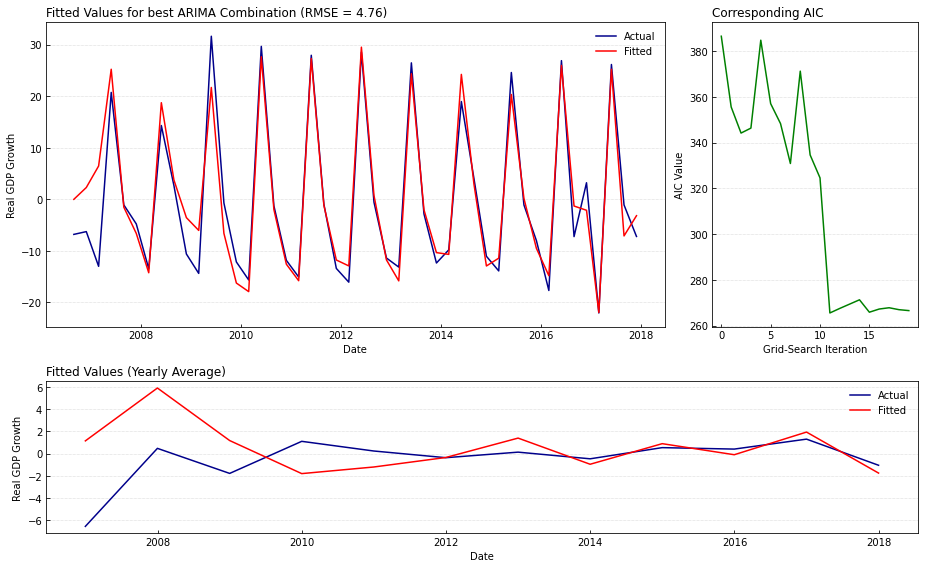

In [14]:
# visualize the model training
plot_model(model_data, aic_values, rmse)

In [15]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 16, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

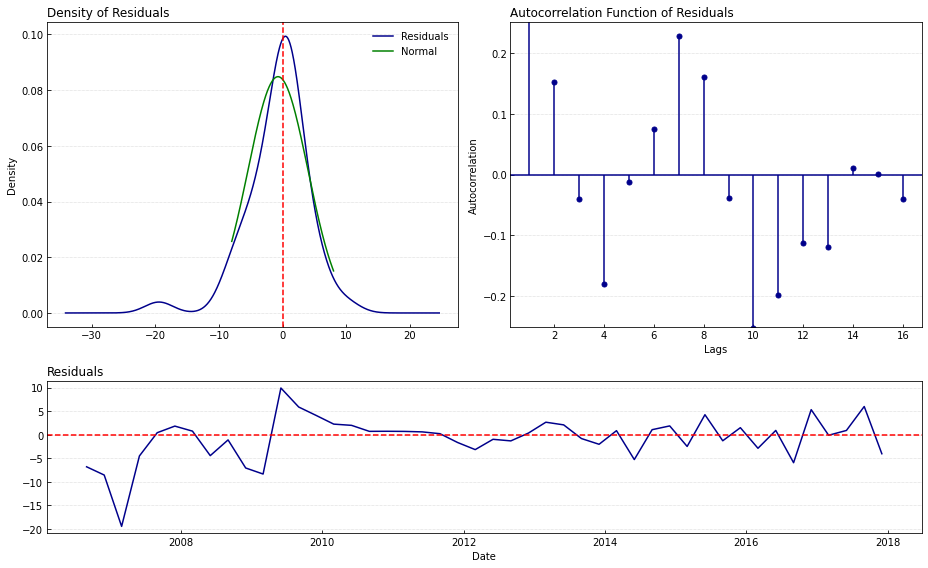

In [16]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

In [17]:
# source code from statsmodels for Goldfeld-Quandt test
def heteroskedasticity_test(resid):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    return test_statistic, p_value

In [18]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

In [19]:
gq_test(residuals)

> goldfeld-quandt test results:
> test statistic = 0.23
> p-value = 0.01


In [20]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("> ljung-box test results:")
    print("> average test statistic = %.2f" % (test_statistic))
    print("> average p-value = %.2f" % (p_value))

In [21]:
lbq_test(residuals)

> ljung-box test results:
> average test statistic = 14.77
> average p-value = 0.19


In [22]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

In [23]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 40.23
> p-value = 0.00
> estimated skew = -1.23
> estimated kurtosis = 6.86


In [56]:
history = [x for x in training.values]
predictions = list()
ci_lower = list()
ci_upper = list()
# walk-forward validation
for t in range(len(testing.values)):
    model = ARIMA(history, order = best_cfg)
    model_fit = model.fit()
    # compute forecast with 80% confidence interval
    y_hat = model_fit.get_forecast().summary_frame(alpha = 0.2)
    predictions.append(y_hat["mean"][0])
    ci_lower.append(y_hat["mean_ci_lower"][0])
    ci_upper.append(y_hat["mean_ci_upper"][0])
    history.append(np.asarray([y_hat["mean"][0]]))
    date = str.split(str(testing.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat["mean"][0], testing.values[t]))
# evaluate forecasts using rmse
rmse = np.sqrt(mean_squared_error(testing.values, predictions))
# save original data and predicted values
forecast_data = testing.copy()
forecast_data["prediction"] = predictions
forecast_data["mean_ci_lower"] = ci_lower
forecast_data["mean_ci_upper"] = ci_upper

> (2018-03-01) forecasted = -17.06; actual = -17.71
> (2018-06-01) forecasted = 24.60; actual = 24.14
> (2018-09-01) forecasted = -0.43; actual = -2.71
> (2018-12-01) forecasted = -7.10; actual = -8.86
> (2019-03-01) forecasted = -16.37; actual = -12.10
> (2019-06-01) forecasted = 23.23; actual = 24.39
> (2019-09-01) forecasted = 0.15; actual = -0.63
> (2019-12-01) forecasted = -6.98; actual = -6.83


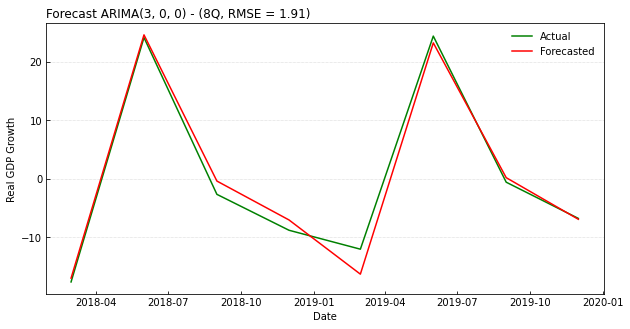

In [57]:
plt.figure(figsize = (10,5))
plt.plot(forecast_data.iloc[:,0], color = "green", label = "Actual")
plt.plot(forecast_data.iloc[:,1], color = "red", label = "Forecasted")
# plt.fill_between(forecast_data.index, forecast_data["mean_ci_lower"], forecast_data["mean_ci_upper"], 
#                 color = "k", alpha = 0.1, label = r"CI ($\alpha = 0.2$)")
plt.xlabel("Date")
plt.ylabel("Real GDP Growth")
plt.title("Forecast ARIMA%s - (8Q, RMSE = %.2f)" % (best_cfg, rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()